### Гежес Петр, Задание 2

## 1. Задачи

### 1.1 Ответы в листьях регрессионного дерева
У варианта с выбором случайного есть серьезный недостаток: какой-нибудь выброс из одного класса, близкий по признакам к другому, спокойно может оказаться в этом листе, и если мы его выберем, будет неприятно. Вариант со средним кажется гораздо более предсказуем и стабилен.

### 1.2 Линейные модели в деревьях
По факту, в листьях дерева, обученного по MSE, никакой линейной модели в листьях наблюдаться не должно

## 2. Применение решающего дерева

In [21]:
import pydotplus 
import pandas as pd
from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('german.data-numeric.csv', sep = '\s+')

Насколько я понял, классы - последний столбец (1 - надежный клиент, выдаем кредит, 2 - нет). Разбиваем, обучаем:

(Максимальная глубина подобрана так, чтобы минимизировать ошибку)

In [16]:
train_data, test_data, train_target, test_target = train_test_split(data[data.columns[:-1]], data[[-1]],
                                                                   test_size = 0.2)

In [17]:
model = tree.DecisionTreeClassifier(max_depth = 5)
model.fit(train_data, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

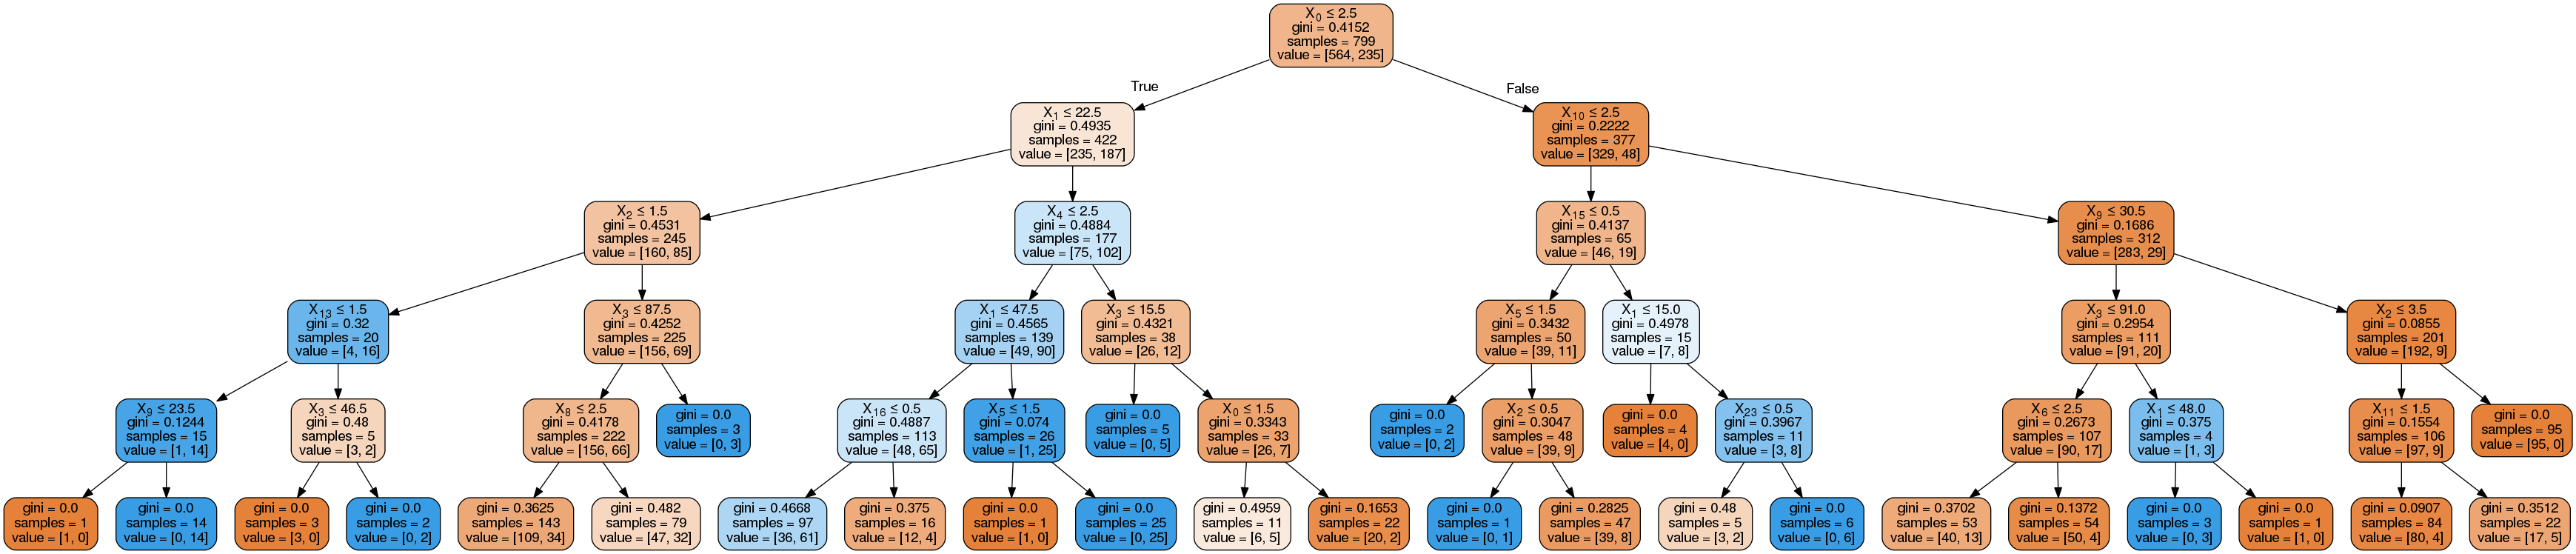

In [18]:
dot_data = tree.export_graphviz(model, out_file="tree.out",
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")  
Image(graph.create_png())

In [23]:
score = []
for depth in range(1, 40):
    model = tree.DecisionTreeClassifier(max_depth = depth)
    model.fit(train_data, train_target)
    test_predictions = model.predict(test_data)
    score.append(accuracy_score(test_target, test_predictions))

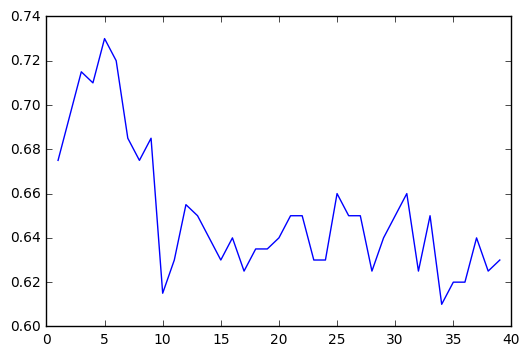

In [24]:
plt.plot(range(1, 40), score)
plt.show()

Как видим, качество не очень хорошее (и сильно нестабильно). Вероятно, это не тот случай, когда решающие деревья - лучший выбор.
Тем не менее, видно, что лучшие значение получаются при адекватной глубине (около пяти)

## 3. Реализация решающего дерева

In [25]:
from sklearn.datasets import load_boston
from scipy.optimize import minimize, OptimizeResult

In [35]:
class SimpleDecisionTree:
    class Node:
        def __init__(self, data, result):
            self.train_data = data
            self.result = result
            self.left = False
            self.right = False
            self.criterion = -1
            self.value = 0
            
        
    def __init__(self, max_depth = +np.inf, method = 'CG'):
        '''
        method parameter should be appropriate for scipy.optimize.minimize or a positive number.
        If method is a number, grid with such density will be used instead.
        '''
        self.max_depth = max_depth
        self.method = method
    
    def __count_err(self, data, left_result, right_result, criterion, value):
        data_left = data[data[:,criterion] <= value]
        data_right = data[data[:,criterion] > value]
        return np.average(np.append(data_left[:,-1] - left_result, data_right[:,-1] - right_result) ** 2)
    
    def __grid_minimize(self, node, criterion):
        mins = OptimizeResult()
        mins.fun = np.inf
        res_grid = np.linspace(self.min_target, self.max_target, self.method)
        val_grid = np.linspace(np.min(node.train_data[:, criterion]), np.max(node.train_data[:, criterion]),
                               self.method)
        for left_result in res_grid:
            for right_result in res_grid:
                for value in val_grid:
                    fun_value = self.__count_err(node.train_data, left_result, right_result, criterion, value)
                    if fun_value < mins.fun:
                        mins.fun = fun_value
                        mins.x = [value, left_result, right_result]
                        mins.success = True
        return mins
    
    def __split_node(self, node, depth):
        if depth >= self.max_depth or len(node.train_data) <= 1:
            return
        best_err = np.inf
        best_criterion = -1
        best_value = 0
        best_left_result = node.result
        best_right_result = node.result
        
        for criterion in range(self.num_criterion):
            if type(self.method) == int:
                mins = self.__grid_minimize(node, criterion)
            else:
                mins = minimize(lambda v: 
                            self.__count_err(node.train_data, v[1], v[2], criterion, v[0]),
                           [node.train_data[0][criterion], self.min_target, self.max_target], method = self.method)
            if mins.fun < best_err:
                best_err = mins.fun
                best_criterion = criterion
                best_value = mins.x[0]
                best_left_result = mins.x[1]
                best_right_result = mins.x[2]
        
        if best_criterion == -1:
            return
        left_data = node.train_data[node.train_data[:, best_criterion] <= best_value]
        right_data = node.train_data[node.train_data[:, best_criterion] > best_value]
        if len(left_data) == 0 or len(right_data) == 0:
            return
        node.criterion = best_criterion
        node.value = best_value
        node.left = self.Node(left_data, best_left_result)
        node.right = self.Node(right_data, best_right_result)
        self.__split_node(node.left, depth + 1)
        self.__split_node(node.right, depth + 1)
    
    def __predict_one(self, row, node):
        if (node.left or node.right):
            if row[node.criterion] <= node.value:
                return self.__predict_one(row, node.left)
            else:
                return self.__predict_one(row, node.right)
        else:
            return node.result
                   
    
    def fit(self, data, target):
        self.max_target = np.max(target)
        self.min_target = np.min(target)
        self.num_criterion = len(data[0])
        self.root = self.Node(np.hstack((data, target.reshape((len(target), 1)))),
                              (self.min_target + self.max_target) / 2)
        self.__split_node(self.root, 0)
    
    def predict(self, data):
        target = np.zeros(len(data))
        for i in range(len(data)):
            target[i] = self.__predict_one(data[i], self.root)
        return target
    
    def __print_subtree(self, node, tab):
        if (node.left or node.right):
            print(tab + 'if x_' + str(node.criterion) + ' <= ' + str(node.value) + ' {')
            self.__print_subtree(node.left, tab + '  ')
            print(tab + '} else {')
            self.__print_subtree(node.right, tab + '  ')
            print(tab + '}')
        else:
            print(tab + 'return ' + str(node.result))

    def print_tree(self):
        self.__print_subtree(self.root, '')
        

In [40]:
data = load_boston()
train_data, test_data, train_target, test_target = train_test_split(data.data, data.target,
                                                                   test_size = 0.2)
print(train_data[:3])
print(train_target[:3])

[[  5.73500000e-02   0.00000000e+00   4.49000000e+00   0.00000000e+00
    4.49000000e-01   6.63000000e+00   5.61000000e+01   4.43770000e+00
    3.00000000e+00   2.47000000e+02   1.85000000e+01   3.92300000e+02
    6.53000000e+00]
 [  7.84200000e-01   0.00000000e+00   8.14000000e+00   0.00000000e+00
    5.38000000e-01   5.99000000e+00   8.17000000e+01   4.25790000e+00
    4.00000000e+00   3.07000000e+02   2.10000000e+01   3.86750000e+02
    1.46700000e+01]
 [  2.99160000e-01   2.00000000e+01   6.96000000e+00   0.00000000e+00
    4.64000000e-01   5.85600000e+00   4.21000000e+01   4.42900000e+00
    3.00000000e+00   2.23000000e+02   1.86000000e+01   3.88650000e+02
    1.30000000e+01]]
[ 26.6  17.5  21.1]


In [41]:
model = SimpleDecisionTree(5)
model.fit(train_data, train_target)

In [42]:
model.print_tree()

if x_12 <= 6.53 {
  if x_5 <= 6.63 {
    if x_6 <= 56.1 {
      if x_10 <= 18.5 {
        if x_11 <= 392.3 {
          return 27.0285699934
        } else {
          return 25.1833353303
        }
      } else {
        if x_10 <= 19.6 {
          return 24.6428564779
        } else {
          return 21.9000073123
        }
      }
    } else {
      if x_0 <= 1.27346 {
        if x_6 <= 92.6 {
          return 26.2468185257
        } else {
          return 32.0014959082
        }
      } else {
        return 50.0
      }
    }
  } else {
    if x_5 <= 6.976 {
      if x_4 <= 0.573 {
        if x_1 <= 0.0 {
          return 24.3249973859
        } else {
          return 31.2687499302
        }
      } else {
        if x_2 <= 18.1 {
          return 50.0000021738
        } else {
          return 41.2999995708
        }
      }
    } else {
      if x_11 <= 395.62 {
        if x_10 <= 18.3 {
          return 44.295650533
        } else {
          return 35.0999898831
        }
  

Выбор оптимального разбиения во время обучения - пожалуй, самая важная часть класса.

Я пробовал перебор всего по сетке, минимизация порога и перебор остального по сетке
и минимизация всего (минимизация при помощи scipy.optimize.minimize). (Между первыми двумя разницы почти не обнаружил, т.е. основной вклад в ошибку дает неточная минимизация значений, а не порога).
Кроме того, для минимизации пробовал все алгоритмы, которые есть в базовом наборе этой функции. Некоторые из них, такие как симплексный Nelder-Mead, работают очень плохо; остальные работают сильно по-разному в зависимости от разбиения, хотя, все равно, все они хуже чем разбиение сеткой. Неочевидно, почему сетка работает лучше всего, вроде бы данные непрерывные.

Очевидно, это все же будет сильно зависеть от данных, поэтому я оставил возможность указывать это в конструкторе. Я оставил дефолтной CG, а не сетку, так как у сетки есть один большой минус: она работает на пару порядков
медленнее чем любой алгоритм minimize.

Ниже приведены сравнительные значения среднего квадрата ошибки для того же datasets.boston:

In [43]:
for method in ['BFGS', 'Nelder-Mead', 'Powell', 'CG', 15]: #15 means grid with 15 cells
    model = SimpleDecisionTree(5, method)
    model.fit(train_data, train_target)
    predicted = model.predict(test_data)
    print(str(method) + ': ' + str(np.average((predicted - test_target) ** 2)))

BFGS: 36.5834845008
Nelder-Mead: 78.8064510156
Powell: 35.9144902226
CG: 36.5446732486
15: 26.5281232493


Ниже, для сравнения, средний квадрат отклонения

In [48]:
avg = np.average(data.target)
print(np.average((avg - data.target) ** 2))

84.4195561562


И сравним с деревом из sklearn.tree

In [47]:
model = tree.DecisionTreeRegressor(max_depth = 5)
model.fit(train_data, train_target)
predicted = model.predict(test_data)
print(np.average((predicted - test_target) ** 2))

12.4845166086
